# Deep Learning with PyTorch : Build a Generative Adversarial Network

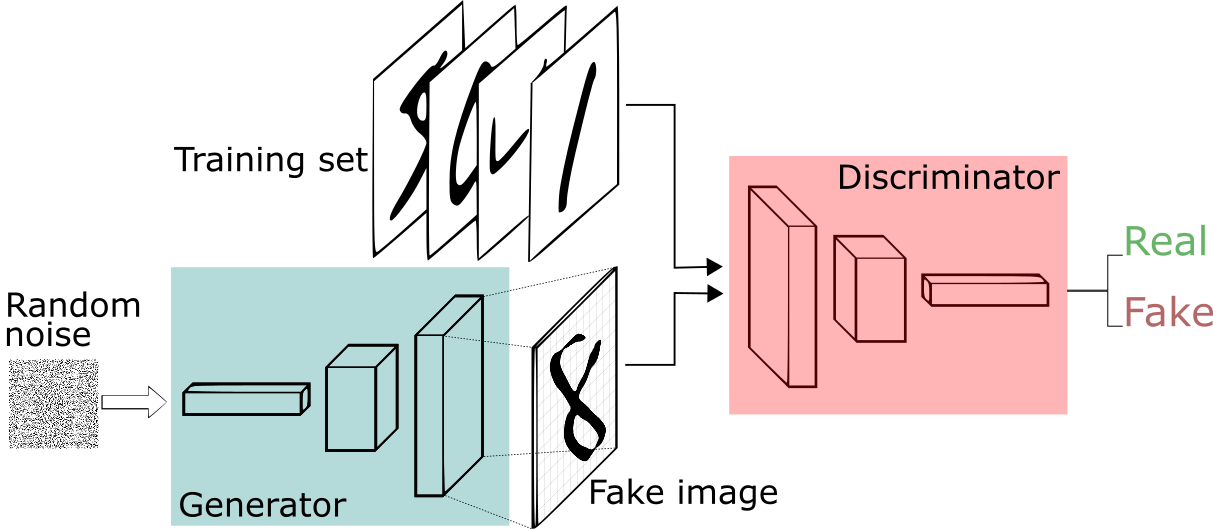

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
DEVICE = 'cuda'
NOISE_DIM = 64

# optimizer parameters
LR = 0.0002
BETA_1 = 0.5
BETA_2 = 0.99

# training variables
EPOCHS = 30
BATCH_SIZE = 128


# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T


In [4]:
train_augs = T.Compose([
    T.RandomRotation((-20,+20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)

])

In [5]:
trainset = datasets.MNIST("MNIST/", download = True, train = True, transform = train_augs)

In [6]:
trainset = datasets.MNIST("CIFAR/", download = True, train = True, transform = train_augs)

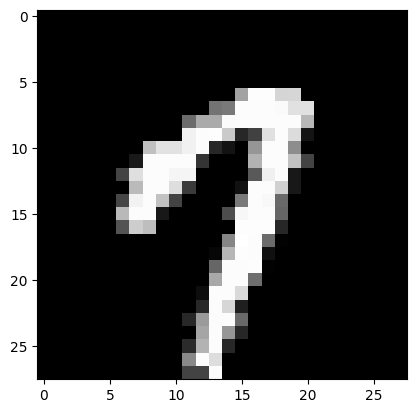

In [7]:
image , label = trainset[15]

plt.imshow(image.squeeze(), cmap = 'gray')

In [8]:
print(f'total number of training images are {len(trainset)}')

total number of training images are 60000


# Load Dataset Into Batches

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)

In [11]:
print(f"total number of batchs in trainloader are {len(trainloader)}")

total number of batchs in trainloader are 469


In [12]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [13]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

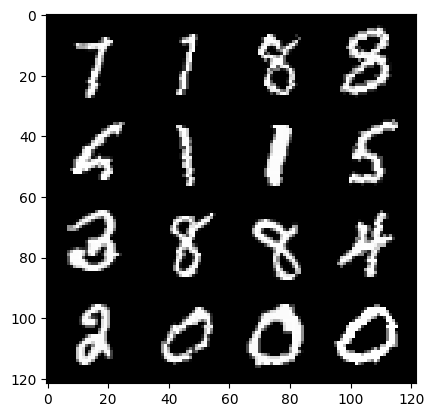

In [14]:
show_tensor_images(images)

# Create Discriminator Network

In [15]:
#In case if torch summary is not installed

!pip install torchsummary

In [16]:
from torch import nn
from torchsummary import summary


In [17]:
# '''

# Network : Discriminator

# input : (bs, 1, 28, 28)
#       |                                                                                               ---- SUMMARY ----
#       V
# Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
# BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
# LeakyReLU()                                                                                            #(bs, 16, 13, 13)
#       |
#       V
# Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
# BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
# LeakyReLU()                                                                                            #(bs, 32, 5, 5)
#       |
#       V
# Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
# BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
# LeakyReLU()                                                                                            #(bs, 64, 1, 1)
#       |
#       V
# Flatten()                                                                                              #(bs, 64)
# Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

# '''


In [18]:
def get_dis_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [19]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.block_1 = get_dis_block(1,16,(3,3),2)
    self.block_2 = get_dis_block(16,32,(5,5),2)
    self.block_3 = get_dis_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    return self.linear(x4)



In [20]:
D = Discriminator()
D.to(DEVICE)
summary(D, input_size= (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [21]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [22]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block:
    return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
                         nn.Tanh()
    )
  return nn.Sequential( nn.ConvTranspose2d( in_channels, out_channels, kernel_size, stride),
                       nn.BatchNorm2d(out_channels),
                        nn.ReLU()
                        )




In [23]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator,self).__init__()
    self.noise_dim = noise_dim
    self.gen_block_1 = get_gen_block(noise_dim,256,(3,3),2)
    self.gen_block_2 = get_gen_block(256,128,(4,4),1)
    self.gen_block_3 = get_gen_block(128,64,(3,3),2)
    self.gen_block_4 = get_gen_block(64,1,(4,4), 2, final_block=True)

  def forward(self, r_noise_vec):

    x = r_noise_vec.view(-1, self.noise_dim,1,1)  # change the input share from (bs,noise_dim)  --> (bs,noise_dim,1,1)
    x1 = self.gen_block_1(x)
    x2 = self.gen_block_2(x1)
    x3 = self.gen_block_3(x2)
    x4 = self.gen_block_4(x3)

    return x4


In [24]:
G = Generator(NOISE_DIM)
G.to(DEVICE)

summary(G, input_size = (1, NOISE_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [25]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [26]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [27]:
# 2 loss, one real and other fake for discriminator loss and generator loss
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss
def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss


In [28]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR, betas= (BETA_1,BETA_2))
G_opt = torch.optim.Adam(G.parameters(), lr=LR, betas= (BETA_1,BETA_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 | D_loss: 0.6686219785259222 | G_loss: 0.7065227997582605


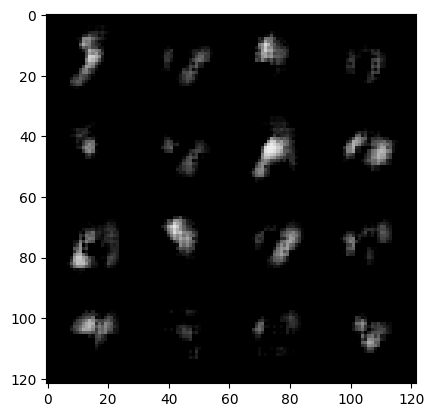

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1 | D_loss: 0.6343004703521729 | G_loss: 0.7568144744901515


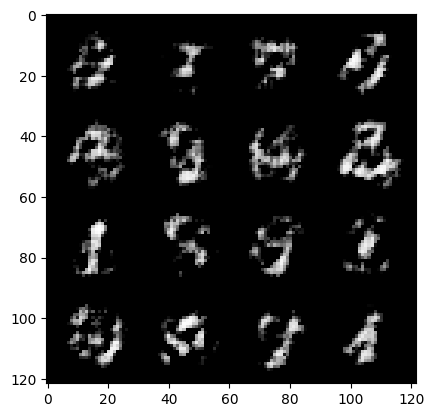

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 2 | D_loss: 0.6237019210227771 | G_loss: 0.7726346526318776


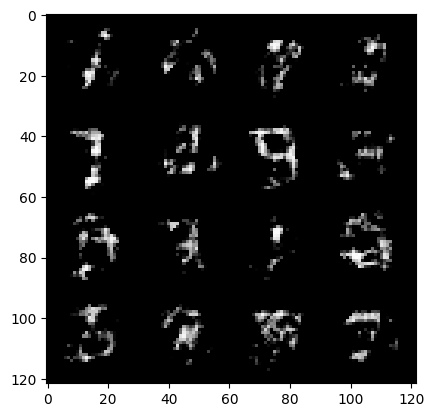

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 3 | D_loss: 0.5554012565978809 | G_loss: 0.8697935372019119


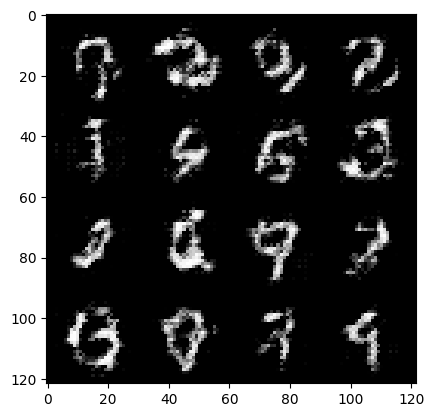

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 4 | D_loss: 0.5245234230433954 | G_loss: 0.9260874423645199


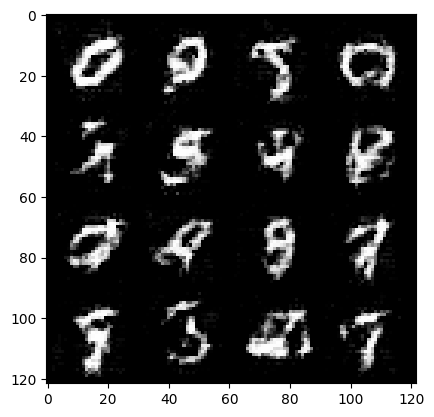

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 5 | D_loss: 0.5206368685022854 | G_loss: 0.9488981554248949


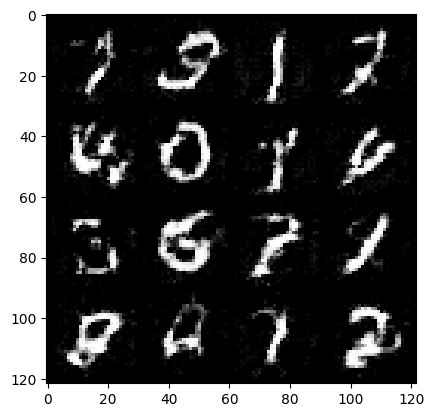

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 6 | D_loss: 0.5284705244020612 | G_loss: 0.9582495433943612


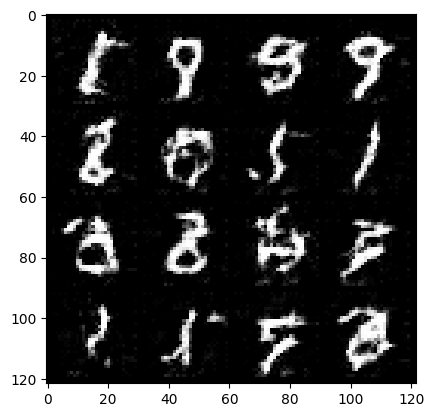

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 7 | D_loss: 0.538123215248844 | G_loss: 0.9545079908137128


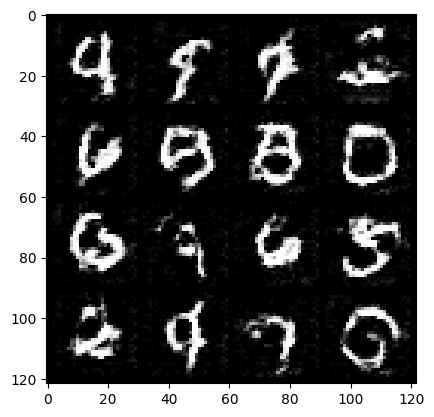

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 8 | D_loss: 0.5524347490593314 | G_loss: 0.9420859831482616


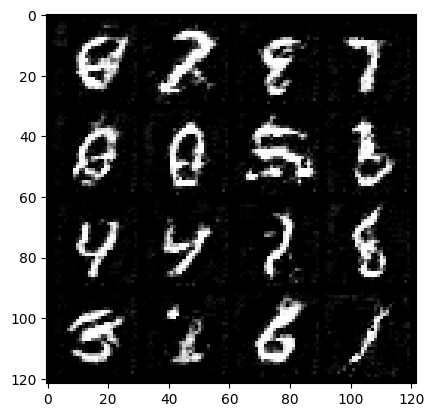

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 9 | D_loss: 0.5645700696943157 | G_loss: 0.9323205836037837


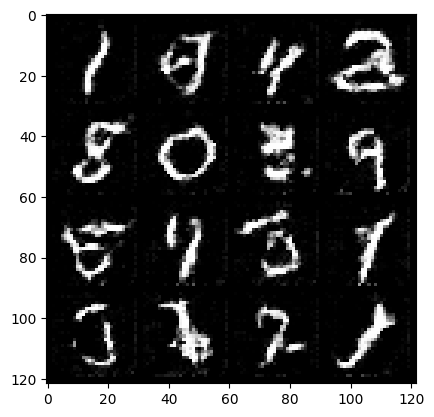

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 10 | D_loss: 0.574452170049712 | G_loss: 0.9212529323756822


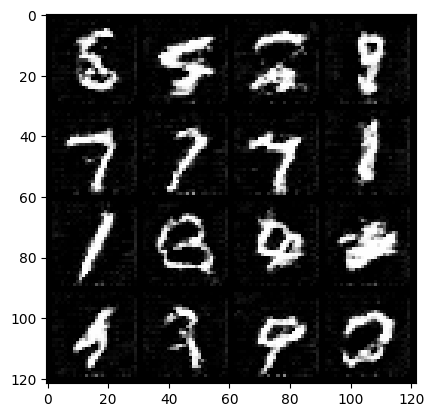

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 11 | D_loss: 0.5803982410857926 | G_loss: 0.9164751629585396


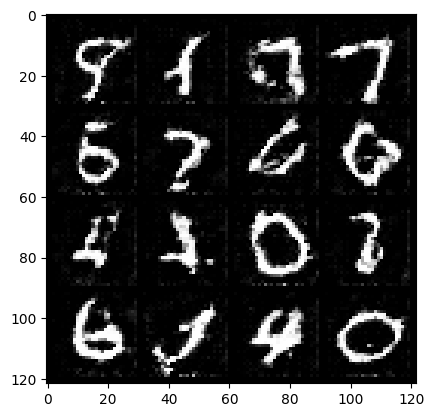

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 12 | D_loss: 0.5849869096202891 | G_loss: 0.9162234028519344


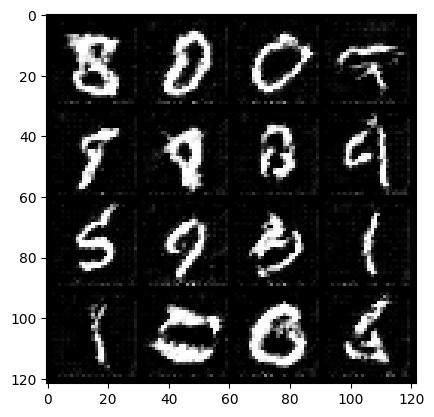

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 13 | D_loss: 0.5872642111930766 | G_loss: 0.9139901272523632


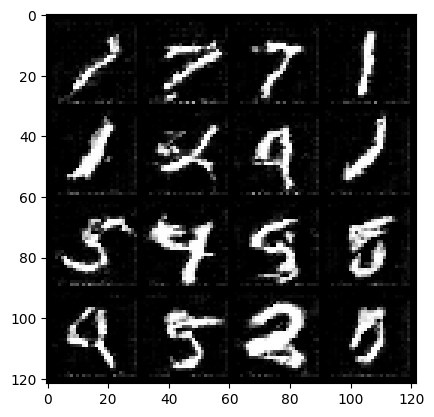

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 14 | D_loss: 0.5904268951558355 | G_loss: 0.9126261895907714


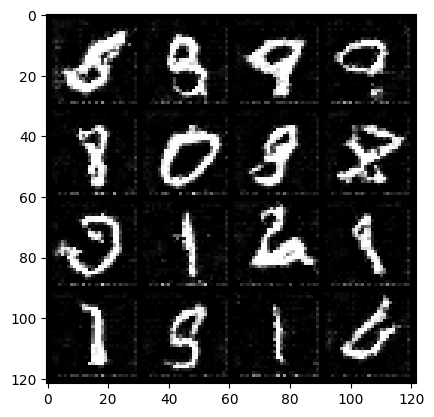

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 15 | D_loss: 0.5923201199025233 | G_loss: 0.9168243418370229


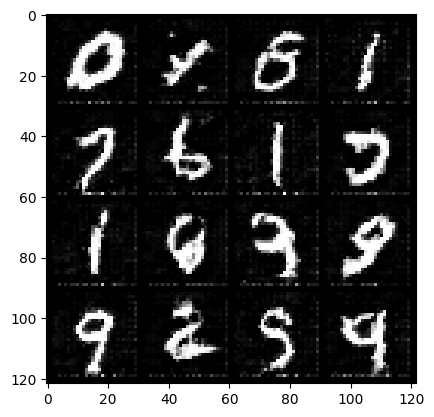

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 16 | D_loss: 0.5897948116635972 | G_loss: 0.9183312338044141


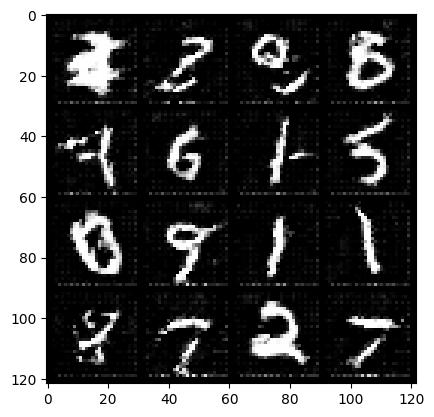

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 17 | D_loss: 0.5893898108112279 | G_loss: 0.9204023054667881


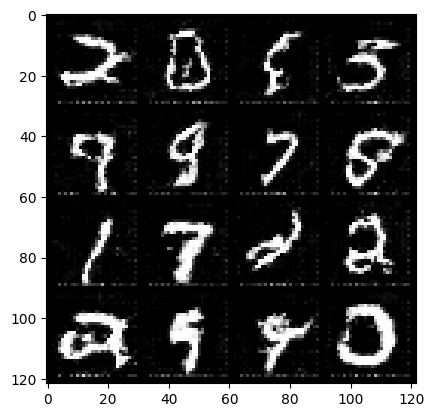

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 18 | D_loss: 0.5894336427198544 | G_loss: 0.9263674048726747


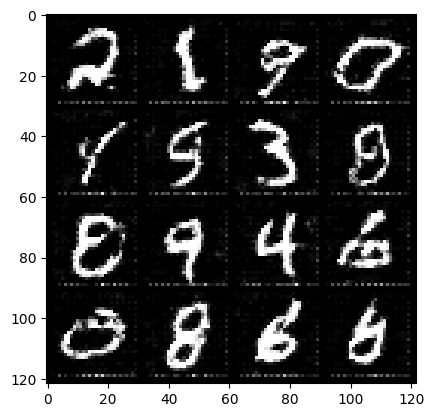

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 19 | D_loss: 0.5885497733219854 | G_loss: 0.92866201784565


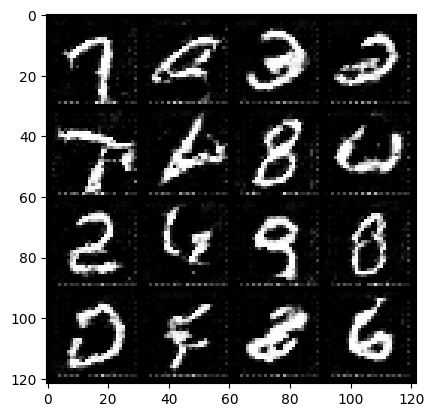

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 20 | D_loss: 0.5876917938179553 | G_loss: 0.9339125335597789


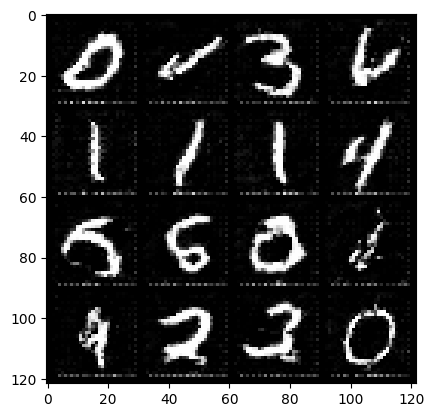

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 21 | D_loss: 0.5858077228958927 | G_loss: 0.9395796024977271


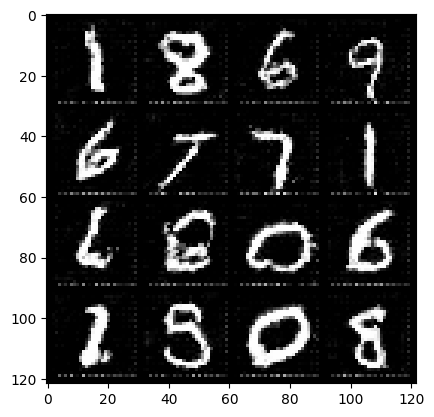

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 22 | D_loss: 0.5827246171070822 | G_loss: 0.9422405473967351


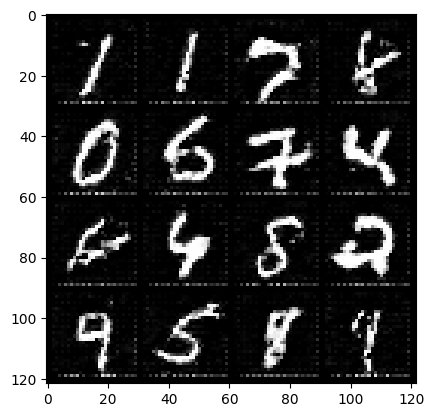

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 23 | D_loss: 0.5819934110905824 | G_loss: 0.9513802101362997


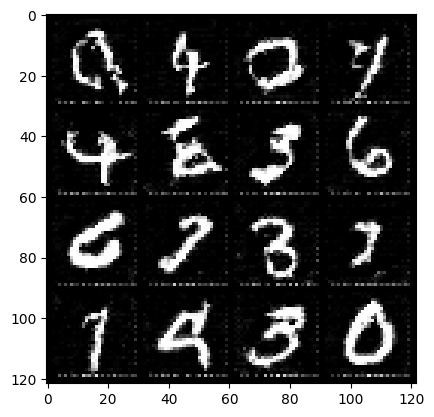

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 24 | D_loss: 0.5826750742092824 | G_loss: 0.957149596864989


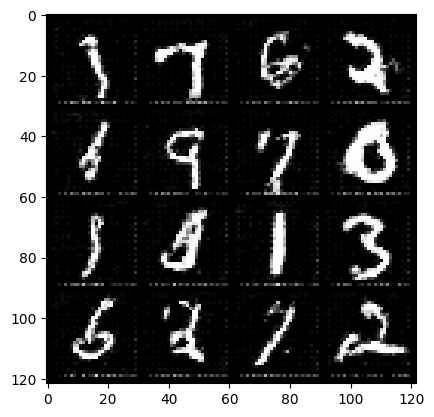

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 25 | D_loss: 0.5811781623978605 | G_loss: 0.958849603814611


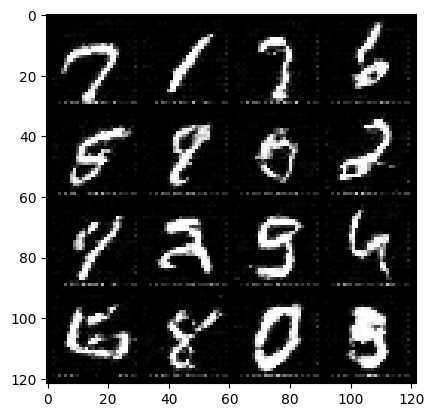

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 26 | D_loss: 0.5799463904742748 | G_loss: 0.965006657627854


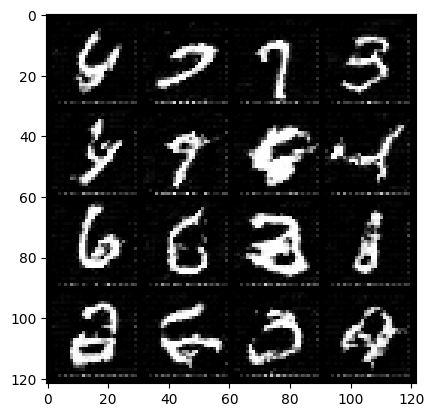

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 27 | D_loss: 0.5779052672864023 | G_loss: 0.9675214784994308


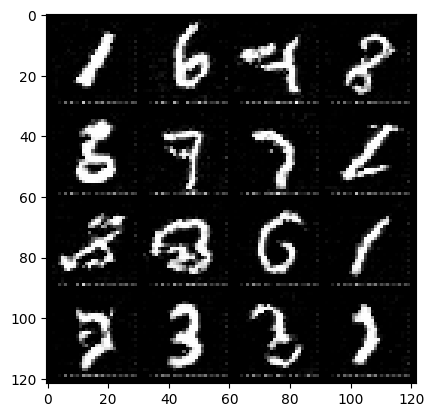

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 28 | D_loss: 0.5768006055085644 | G_loss: 0.9775336496611394


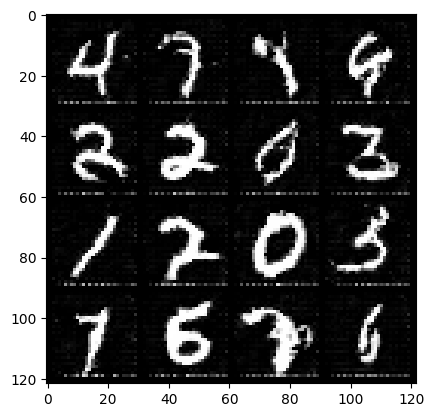

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 29 | D_loss: 0.5784671729815795 | G_loss: 0.9776267714337754


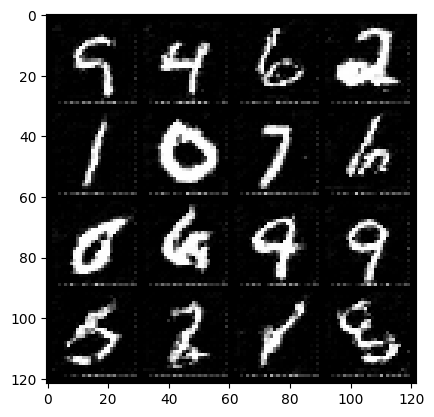

In [29]:
d_losses = []
g_losses = []
for i in range(EPOCHS):
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(DEVICE)
    noise = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)

    # Calculate the loss and update weights for D
    D_opt.zero_grad()
    G_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)
    D_loss = (D_real_loss + D_fake_loss)/2
    total_d_loss += D_loss.item()
    D_loss.backward()
    D_opt.step()
    #find loss and update wrights for generator network

    noise = torch.randn(BATCH_SIZE, NOISE_DIM, device = DEVICE)
    fake_image = G(noise)
    D_pred = D(fake_image)
    G_loss = real_loss(D_pred)
    total_g_loss +=G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)
  d_losses.append(avg_d_loss)
  g_losses.append(avg_g_loss)
  print(f'EPOCH: {i} | D_loss: {avg_d_loss} | G_loss: {avg_g_loss}')



  show_tensor_images(fake_img)

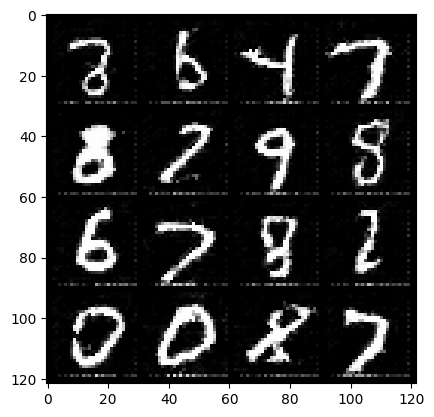

In [30]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(BATCH_SIZE, NOISE_DIM, device = DEVICE)
generated_image = G(noise)

show_tensor_images(generated_image)

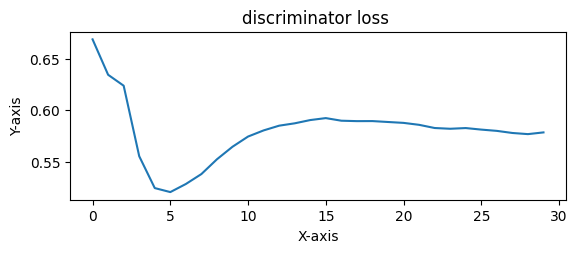

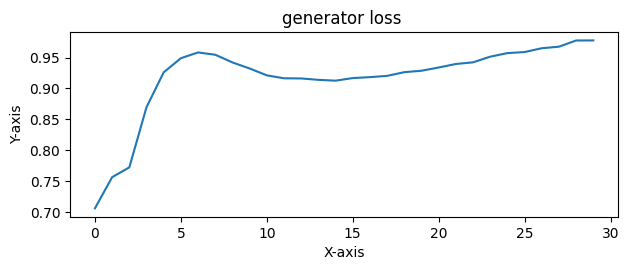

In [31]:
import matplotlib.pyplot as plt

# Sample data (replace with your own lists of float values)
list1 = d_losses[:]
list2 = g_losses[:]

# Create a figure and axis for the first graph
plt.figure(1)
plt.subplot(211)  # 2 rows, 1 column, 1st plot
plt.plot(list1)
plt.title('discriminator loss ')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Create a figure and axis for the second graph
plt.figure(2)
plt.subplot(212)  # 2 rows, 1 column, 2nd plot
plt.plot(list2)
plt.title('generator loss ')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plots
plt.tight_layout()
plt.show()


In [37]:
BATCH_SIZE = 64  # Replace with your desired batch size
NOISE_DIM = 100  # Replace with your desired noise dimension
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'



p = 0.3  # Probability of success
# Create a random noise vector using a Poisson distribution
lambda_ = 3.0  # Poisson rate parameter
# Create a random noise vector using a Exponential distribution
rate = 0.5  # Rate parameter (inverse of the mean)

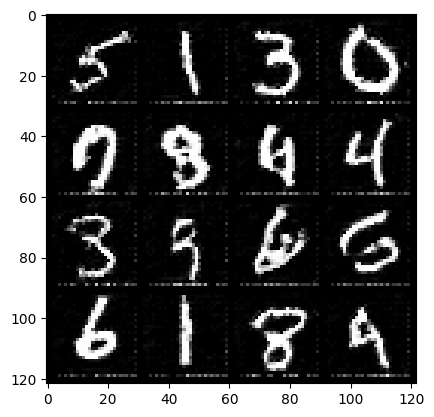

In [38]:
noise = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)

generated_image = G(noise)

show_tensor_images(generated_image)



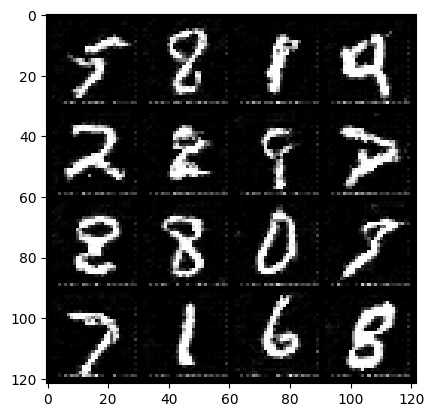

In [39]:
noise = torch.rand(BATCH_SIZE, NOISE_DIM, device=DEVICE) * 2 - 1
generated_image = G(noise)

show_tensor_images(generated_image)

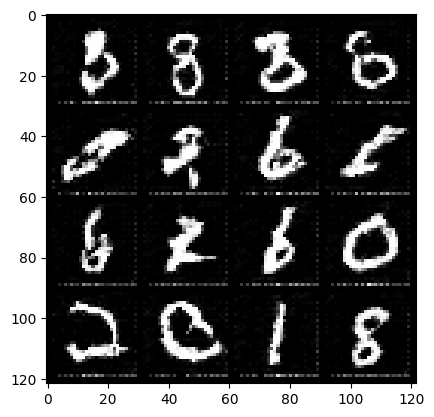

In [40]:
noise = torch.bernoulli(p * torch.ones(BATCH_SIZE, NOISE_DIM, device=DEVICE))
generated_image = G(noise)

show_tensor_images(generated_image)

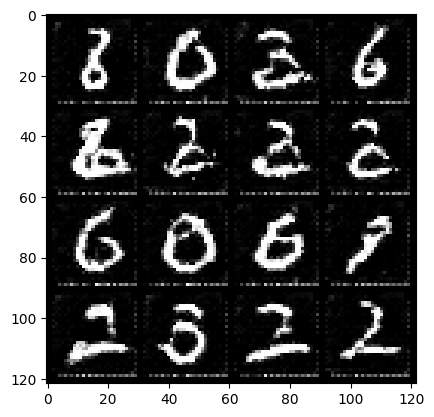

In [41]:
noise = torch.poisson(lambda_ * torch.ones(BATCH_SIZE, NOISE_DIM, device=DEVICE))
generated_image = G(noise)

show_tensor_images(generated_image)